# Kernel Ridge Regression with descriptor (Exercise 34)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("axes", titlesize=16)
plt.rc("font", size=12)
from scipy.spatial.distance import pdist,squareform
from scipy.optimize import fmin
from matplotlib.colors import to_rgba
from cpclasses.PlotTools import save_plot

In [3]:
from week6 import LennardJones, relax
lennard_jones_calc = LennardJones()


In [4]:
from week6 import AtomicCluster

In [5]:
class PairDistances():
    
    def __init__(self, color='C1',xwidth=0.5):
        self.xwidth = xwidth
        self.color = color
        self.bin_edges = np.arange(0,7.01,self.xwidth)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) /2
    
    def descriptor(self,pos):
        bars, _ = np.histogram(pdist(pos),self.bin_edges)
        return bars
    
    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([0,20.1])
        ax.set_title(self.__class__.__name__)
    
pair_distances = PairDistances(xwidth=0.5)

In [6]:
class CoulombMatrixSpectrum():
    
    def __init__(self, color='C4'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self,pos):
        r_matrix = squareform(pdist(pos))
        np.fill_diagonal(r_matrix, 1)
        one_over_r_matrix = r_matrix**-1
        eigen_values, _ = np.linalg.eig(one_over_r_matrix)
        eigen_values = np.real(eigen_values) # ignore any small complex component
        sorted_eigen_values = sorted(eigen_values)
        return sorted_eigen_values

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([-2,8])
        ax.set_title(self.__class__.__name__)
    
coulomb_matrix_spectrum = CoulombMatrixSpectrum()

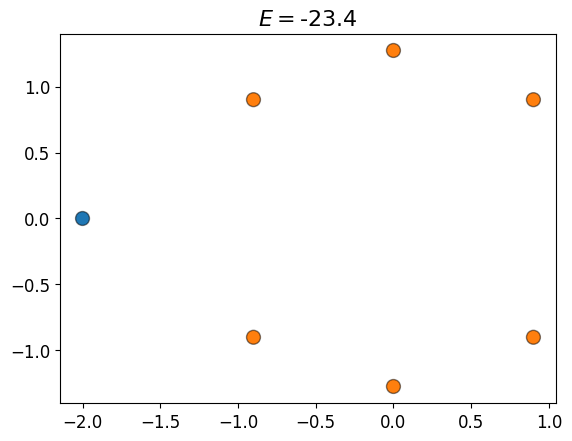

In [7]:

def create_initial_cluster(ring_formed=False, square=True):
    if square:
        pos = [[x,y] for x in np.linspace(-1.5,1.5,3) for y in np.linspace(-1.5,1.5,3)]
        del pos[4]
        del pos[6]
        pos[1] = [-2, 0]
        #pos[2] += np.array([0.5,0])
        #pos[4] += np.array([0.5,0])
       #pos[6] += np.array([0.5,0])
        static = [True] * len(pos)
        static[1] = False

    if ring_formed:
        Nouter = 8
        thetas = np.linspace(0,2*np.pi,Nouter,endpoint=False)
        pos = [ Nouter / 2 / np.pi * np.array([np.cos(theta),np.sin(theta)]) for theta in thetas]
        del pos[4]
        del pos[0]
        pos += [[-2,0]]
        static = (len(pos)-1) * [True] + [False]

    return AtomicCluster(lennard_jones_calc,pos=pos,
                         static=static,
                        descriptor_method=pair_distances)


atomic_cluster = create_initial_cluster(ring_formed=True, square=False)

fig,ax = plt.subplots()

atomic_cluster.draw(ax)

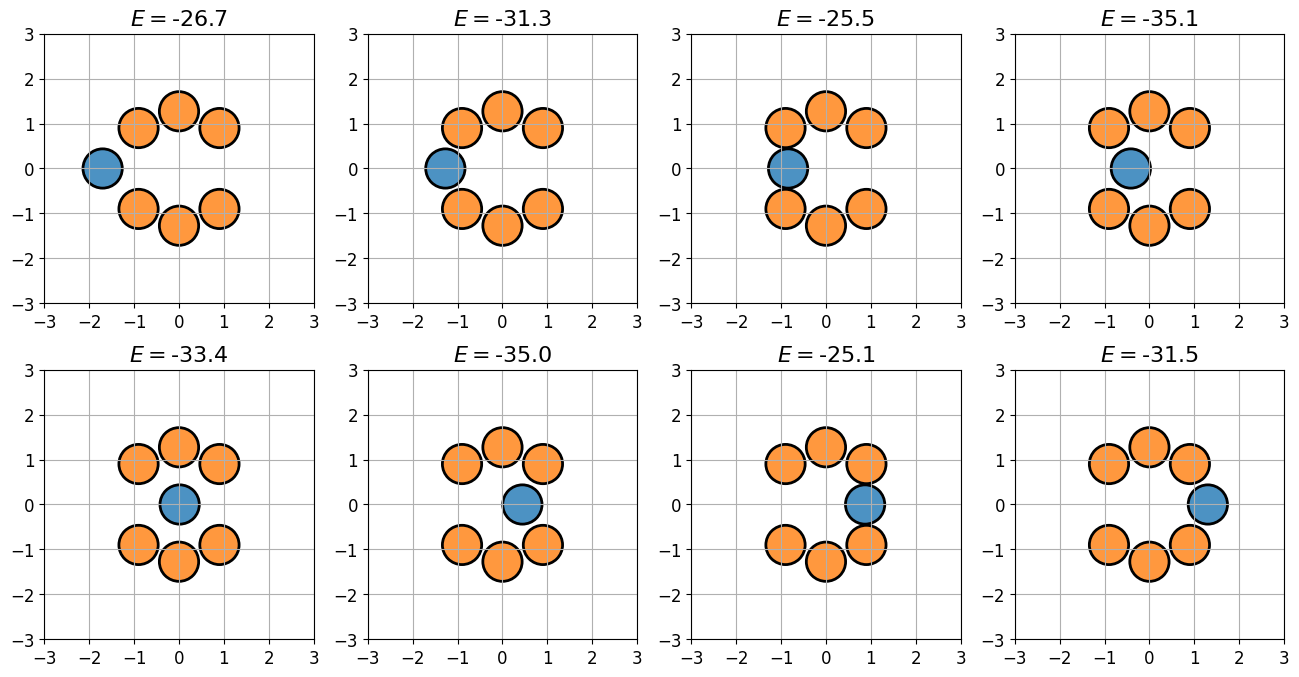

In [8]:
#Create a square cluster:






atomic_cluster = create_initial_cluster(ring_formed=True, square=False)

ring_size = 800
color = 'C0'

fig, axes = plt.subplots(2,4,figsize=(16,8))
xpos = np.linspace(-1.5,1.5,8) - 0.2
data_x = []
data_pair_distance = []
data_coulomb_matrix_spectrum = []
for ax, x in zip(axes.ravel(), xpos):
    pos = atomic_cluster.get_positions()
    pos[-1,0] = x
    atomic_cluster.set_positions(pos)
    atomic_cluster.draw(ax,ring_size,alpha=0.8,edge=True,color=color)
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.set_aspect('equal')
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.grid('on')
    energy = atomic_cluster.potential_energy
    data_x.append((x, energy))
    atomic_cluster.descriptor_method = pair_distances
    data_pair_distance.append((atomic_cluster.descriptor, energy))
    atomic_cluster.descriptor_method = coulomb_matrix_spectrum
    data_coulomb_matrix_spectrum.append((atomic_cluster.descriptor, energy))
    
save_plot(fig, "cluster_energy_vs_x.png")

In [645]:
print(data_x)

[(-1.7, -26.685580058642422), (-1.2714285714285714, -31.33970192941724), (-0.842857142857143, -25.492943719940868), (-0.4142857142857144, -35.12946920475573), (0.01428571428571418, -33.37350504124834), (0.4428571428571428, -35.04880556733129), (0.8714285714285712, -25.086123927086614), (1.3, -31.503390136655742)]


In [646]:
xs = np.linspace(-2,2.5,100)
es = []
for x in xs:
    pos = atomic_cluster.get_positions()
    pos[-1,0] = x
    atomic_cluster.set_positions(pos)
    energy = atomic_cluster.potential_energy
    es.append(energy)

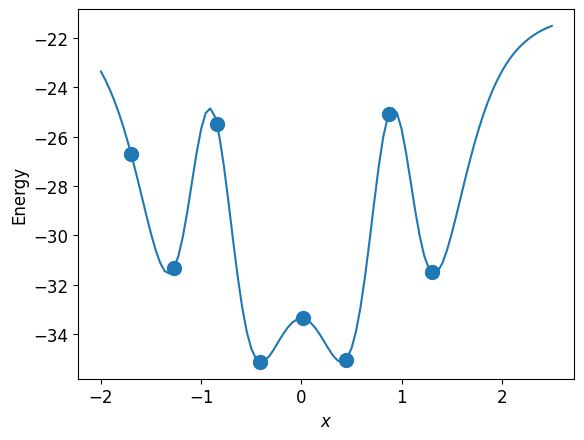

In [647]:
fig, ax = plt.subplots()
ax.plot(xs,es)
ax.scatter([x for x,_ in data_x],[e for _,e in data_x],s=100)
ax.set_xlabel('$x$')
ax.set_ylabel('Energy')

save_plot(fig, "cluster_energy_vs_x.png")

In [648]:
X = [[x] for x,_ in data_x]
X = np.array(X)
X

array([[-1.7       ],
       [-1.27142857],
       [-0.84285714],
       [-0.41428571],
       [ 0.01428571],
       [ 0.44285714],
       [ 0.87142857],
       [ 1.3       ]])

In [649]:
y = np.array([e for _,e in data_x])
y = y.reshape((-1,1))
y

array([[-26.68558006],
       [-31.33970193],
       [-25.49294372],
       [-35.1294692 ],
       [-33.37350504],
       [-35.04880557],
       [-25.08612393],
       [-31.50339014]])

In [650]:
sigma = 1
Kgauss = lambda x: np.exp(-(x - X.T)**2/2/sigma**2)
K = Kgauss(X)

In [651]:
alpha = np.linalg.inv(K + 0.0001 * np.eye(K.shape[0])) @ y
alpha

array([[  2784.31941243],
       [-11383.00285992],
       [ 23190.30601635],
       [-31159.66468186],
       [ 30261.81393494],
       [-21530.60749877],
       [ 10383.97076372],
       [ -2613.53235054]])

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tobia\AppData\Local\Temp\ipykernel_15528\1363456755.py:4: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xfit,yfit,label='plain x descriptor, $\sigma={'+str(sigma)+'}$')


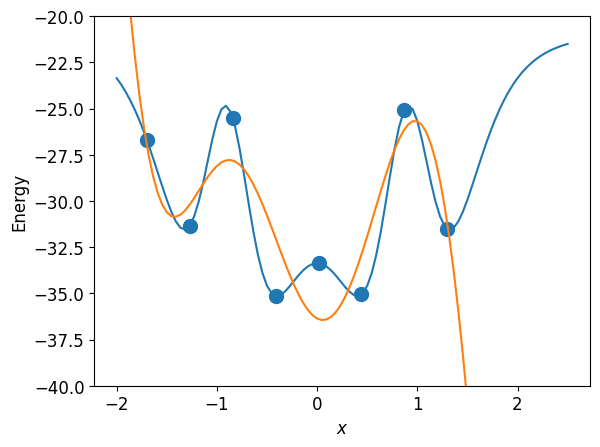

In [652]:
xfit = [np.array([x]) for x in xs]
yfit= [Kgauss(x)[0] @ alpha for x in xfit]

ax.plot(xfit,yfit,label='plain x descriptor, $\sigma={'+str(sigma)+'}$')
#ax.legend()
ax.set_ylim([-40,-20])
fig


In [653]:
sigma = 10
Kgauss = lambda x: np.exp(-(x - X.T)**2/2/sigma**2)
K = Kgauss(X)

In [654]:
alpha = np.linalg.inv(K + 0.0001 * np.eye(K.shape[0])) @ y
alpha

array([[  6476.38985207],
       [-20337.25854072],
       [ 52564.8269039 ],
       [-34788.942581  ],
       [-13714.40088312],
       [-32465.37999989],
       [ 59691.70109963],
       [-17324.59562544]])

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tobia\AppData\Local\Temp\ipykernel_15528\3644057838.py:3: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xfit,yfit,label='plain x descriptor, $\sigma={'+str(sigma)+'}$')


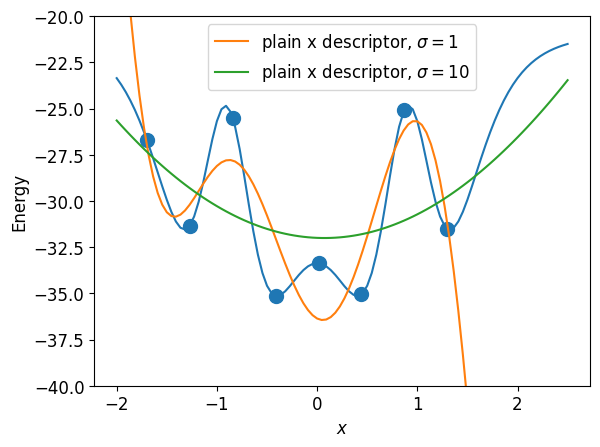

In [655]:
xfit = [np.array([x]) for x in xs]
yfit= [Kgauss(x)[0] @ alpha for x in xfit]
ax.plot(xfit,yfit,label='plain x descriptor, $\sigma={'+str(sigma)+'}$')
ax.legend()

save_plot(fig, "cluster_energy_fit.png")
fig

Text(0, 0.5, 'Energy')

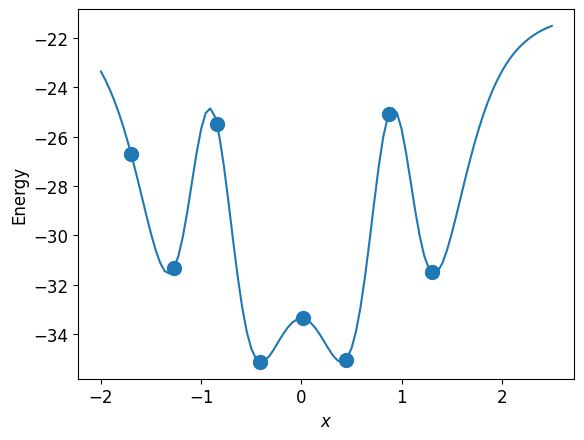

In [656]:
fig, ax = plt.subplots()
ax.plot(xs,es)
ax.scatter([x for x,_ in data_x],[e for _,e in data_x],s=100)
ax.set_xlabel('$x$')
ax.set_ylabel('Energy')

In [657]:
X = [descriptor for descriptor,_ in data_pair_distance]
X = np.array(X)
X

array([[0, 4, 2, 4, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 6, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 8, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 4, 6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 6, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 4, 6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 8, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 6, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [658]:
sigma = 10
def kernel(x):
    x = np.array(x)
    if len(x.shape) == 1:
        diff = x[np.newaxis,np.newaxis,:] - X[np.newaxis, :, :]
    else:
        diff = x[:, np.newaxis, :] - X[np.newaxis, :, :]
    squared_dists = np.sum(diff**2, axis=-1)
    return np.exp(-squared_dists/2/sigma**2)

In [659]:
K = kernel(X)
alpha = np.linalg.inv(K + 0.01 * np.eye(K.shape[0])) @ y
alpha

array([[ 116.58693989],
       [ -84.35780888],
       [  66.51840043],
       [ -92.58981369],
       [  47.21827217],
       [ -84.52344995],
       [ 107.20037972],
       [-100.72662961]])

In [660]:
xfit = []
yfit = []

atomic_cluster.descriptor_method = pair_distances
    
for x in xs:
    xfit.append(x)
    pos = atomic_cluster.get_positions()
    pos[-1,0] = x
    atomic_cluster.set_positions(pos)
    descriptor = atomic_cluster.descriptor
    k = kernel(descriptor)
    fit = kernel(descriptor) @ alpha
    yfit.append(fit[0,0])
ax.plot(xfit,yfit,label='Pair distance, $\sigma={'+str(sigma)+'}$',color='C2')
ax.legend()
fig

save_plot(fig, "cluster_energy_pair_distance.png")

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tobia\AppData\Local\Temp\ipykernel_15528\1138779201.py:15: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xfit,yfit,label='Pair distance, $\sigma={'+str(sigma)+'}$',color='C2')


Text(0, 0.5, 'Energy')

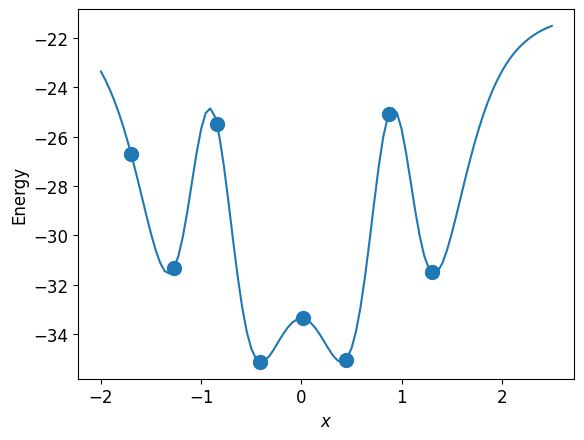

In [661]:
fig, ax = plt.subplots()
ax.plot(xs,es)
ax.scatter([x for x,_ in data_x],[e for _,e in data_x],s=100)
ax.set_xlabel('$x$')
ax.set_ylabel('Energy')

In [662]:
X = [descriptor for descriptor,_ in data_coulomb_matrix_spectrum]
X = np.array(X)
X

array([[-2.46390713e-01, -2.42807928e-01,  1.59795785e-01,
         2.81978347e-01,  9.97392873e-01,  1.45740976e+00,
         4.59262187e+00],
       [-3.54830558e-01, -2.42807928e-01,  3.17573917e-02,
         2.81978347e-01,  1.03227342e+00,  1.45740976e+00,
         4.79421956e+00],
       [-3.98676181e-01, -2.42807928e-01, -1.92362025e-02,
         2.81978347e-01,  9.63302415e-01,  1.45740976e+00,
         4.95802978e+00],
       [-2.50436180e-01, -2.42807928e-01,  9.47882221e-04,
         2.81978347e-01,  7.53128381e-01,  1.45740976e+00,
         4.99977973e+00],
       [-2.42807928e-01, -1.94227271e-01,  9.14026547e-02,
         2.81978347e-01,  6.07533788e-01,  1.45740976e+00,
         4.99871064e+00],
       [-2.60212850e-01, -2.42807928e-01, -4.54165475e-03,
         2.81978347e-01,  7.68756555e-01,  1.45740976e+00,
         4.99941777e+00],
       [-4.03098862e-01, -2.42807928e-01, -1.75976654e-02,
         2.81978347e-01,  9.73067212e-01,  1.45740976e+00,
         4.9510491

In [663]:
sigma = 0.25
K = kernel(X)
alpha = np.linalg.inv(K + 0.01 * np.eye(K.shape[0])) @ y
alpha

array([[-12.58273976],
       [-26.43894968],
       [ -3.3895844 ],
       [  4.80625492],
       [-20.33172896],
       [-19.59984596],
       [ 12.08232823],
       [  4.50056588]])

In [664]:
xfit = []
yfit = []

atomic_cluster.descriptor_method = coulomb_matrix_spectrum
    
for x in xs:
    xfit.append(x)
    pos = atomic_cluster.get_positions()
    pos[-1,0] = x
    atomic_cluster.set_positions(pos)
    descriptor = atomic_cluster.descriptor
    k = kernel(descriptor)
    fit = kernel(descriptor) @ alpha
    yfit.append(fit[0,0])
ax.plot(xfit,yfit, '--', label='Coulomb matrix, $\sigma={'+str(sigma)+'}$' ,color='C4')
ax.legend()
fig

save_plot(fig, "cluster_energy_coulomb_matrix.png")

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tobia\AppData\Local\Temp\ipykernel_15528\2829923137.py:15: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xfit,yfit, '--', label='Coulomb matrix, $\sigma={'+str(sigma)+'}$' ,color='C4')


In [665]:
print(data_x)
print(data_coulomb_matrix_spectrum)
print(data_pair_distance)

#Check if data_coumb_matrix_spectrum has nan or inf or has 0:
for descriptor, energy in data_coulomb_matrix_spectrum:
    if np.isnan(descriptor).any() or np.isinf(descriptor).any() or np.any(descriptor == 0):
        print(0)
        print(descriptor)
        print(energy)


[(-1.7, -26.685580058642422), (-1.2714285714285714, -31.33970192941724), (-0.842857142857143, -25.492943719940868), (-0.4142857142857144, -35.12946920475573), (0.01428571428571418, -33.37350504124834), (0.4428571428571428, -35.04880556733129), (0.8714285714285712, -25.086123927086614), (1.3, -31.503390136655742)]
[([-0.24639071276133914, -0.24280792788409306, 0.15979578530597832, 0.28197834715913217, 0.9973928728223248, 1.457409764486643, 4.592621870871357], -26.685580058642422), ([-0.3548305575269249, -0.24280792788409322, 0.03175739172928769, 0.28197834715913256, 1.0322734211083306, 1.4574097644866442, 4.794219560927623], -31.33970192941724), ([-0.3986761810828084, -0.24280792788409303, -0.019236202530328865, 0.2819783471591326, 0.9633024149809193, 1.457409764486644, 4.958029784870538], -25.492943719940868), ([-0.2504361799870333, -0.24280792788409294, 0.0009478822206098087, 0.28197834715913256, 0.7531283807817125, 1.457409764486645, 4.99977973322303], -35.12946920475573), ([-0.24280